In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled

### Generate data from Normal Means model

Sample $\mathbf{b}$ from a mixture of Gaussians, and sample $\mathbf{y}$ from the multivariate Gaussian $N_n(\mathbf{b}, \mathbb{I}_n)$, where $\mathbb{I}_n$ is the $n \times n$ identity matrix.

$\mathbf{b} \sim \sum_{k = 1}^{K}w_k N(0, \sigma_k^2)$

$\mathbf{y} \sim N_n(\mathbf{\mu}, \mathbb{I}_n)$,

where $n$ is the number of samples.
The posterior probability $\hat{q}(\mathbf{b} \mid \mathbf{y}, w_1, \ldots, w_K, \sigma_1, \ldots, \sigma_K)$ is obtained analytically (using Eq. 26 and 27 of [this document](https://www.overleaf.com/project/60d0d9301e098e4dbe8e3521)).
We also calculate the posterior mean $\mathbf{b}^{*} \triangleq \mathbb{E}_{\hat{q}}[\mathbf{b}]$. 

In [2]:
def sample_mixgauss(wk, sk, size):
    runif = np.random.uniform(0, 1, size = size)
    gcomp = np.digitize(runif, np.cumsum(wk))
    x = np.zeros(size)
    for i, gc in enumerate(gcomp):
        if sk[gc] > 0:
            x[i] = np.random.normal(0, sk[gc]) 
    return x

def NM_sample(mean, std = 1.0):
    p   = mean.shape[0]
    cov = np.eye(p) * std * std
    y   = np.random.multivariate_normal(mean, cov)
    return y

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

Standard deviation of prior mixture components: 0.000, 0.189, 0.414, 0.682

2022-03-09 15:55:54,414 | mrashpen.models.normal_means_ash_scaled | DEBUG | Calculating posterior for NM model.
Mixture coefficients for posterior distribution: 0.899, 0.033, 0.034, 0.034



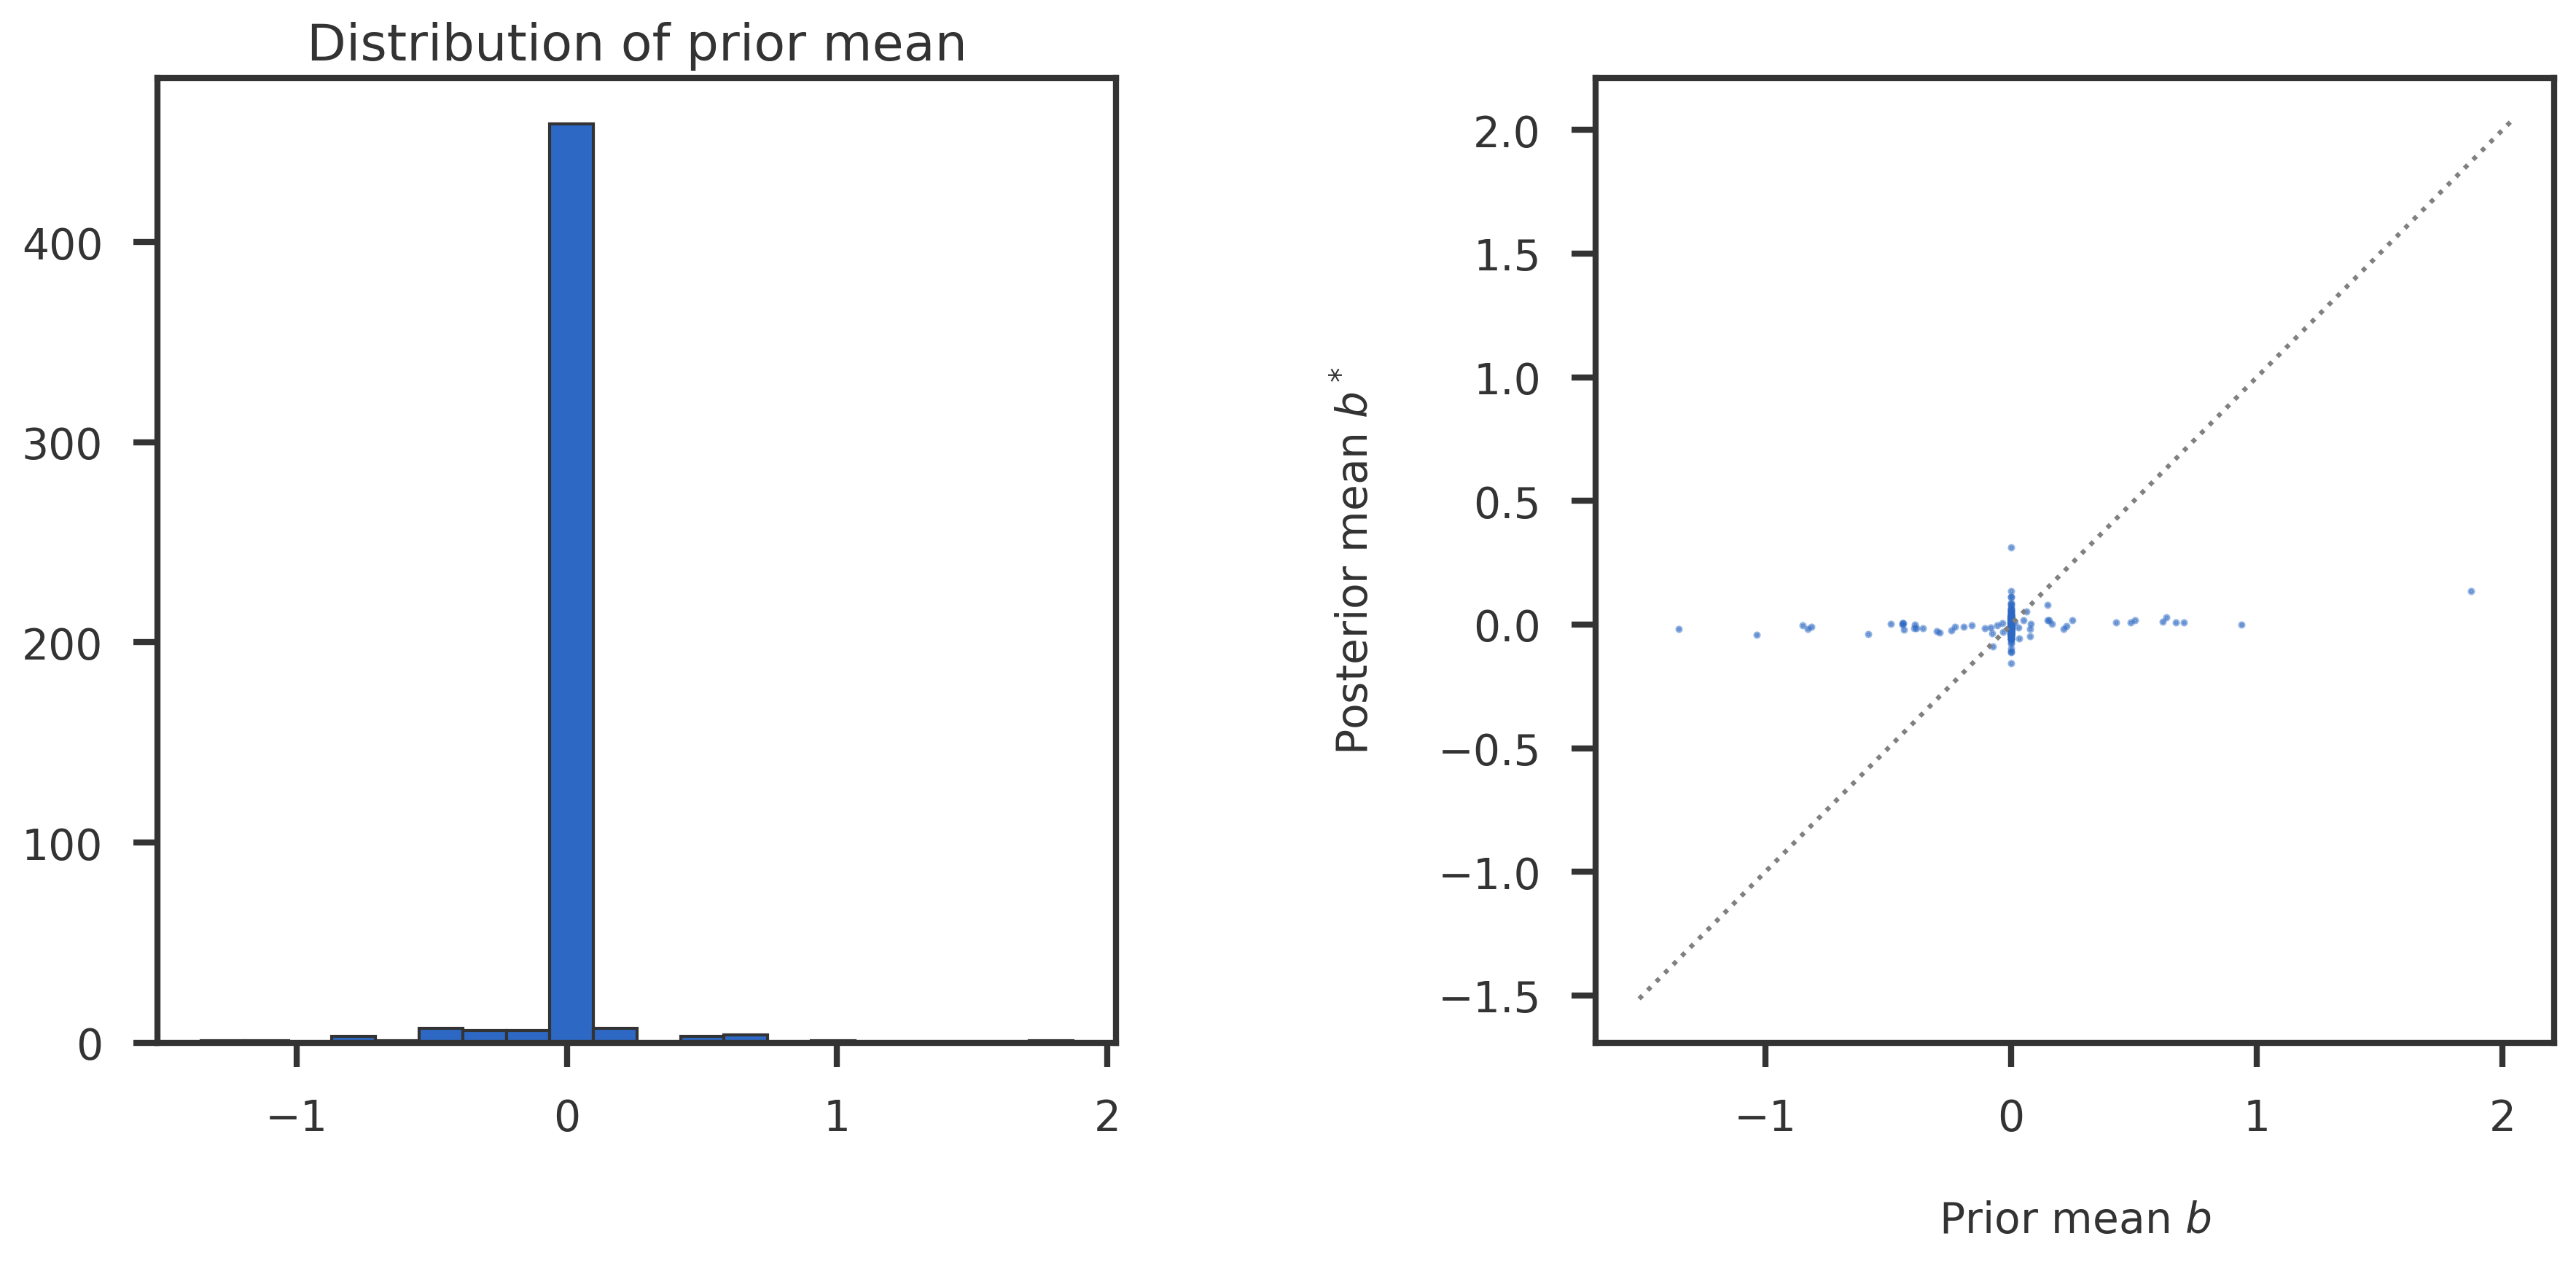

In [3]:
p = 500
k = 4
sparsity = 0.9
strue = 1.0

np.random.seed(100)
wtrue, sk = initialize_ash_prior(k, sparsity = sparsity, scale = 2.0)
#sk = np.logspace(-1, k-2, k)
btrue = sample_mixgauss(wtrue, sk, p)
y = NM_sample(btrue, std = strue)
print ("Standard deviation of prior mixture components: "
       + ', '.join([f"{x:.3f}" for x in sk])
      )
print ()

dj = np.ones(p)
nmash = NormalMeansASHScaled(y, strue, wtrue, sk, d = dj)
qphi, qmu, qvar = nmash.posterior()

bpostmean = np.sum(qphi * qmu, axis = 1)
wpost = np.sum(qphi, axis = 0)
wpost = wpost / np.sum(wpost)
bconst = bpostmean.copy()
print ("Mixture coefficients for posterior distribution: "
       + ', '.join([f"{x:.3f}" for x in wpost])
      )
print ()

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(btrue)
ax1.set_title("Distribution of prior mean")

ax2.scatter(btrue, bpostmean, s=2, alpha = 0.5)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel(r"Prior mean $b$")
ax2.set_ylabel(r"Posterior mean $b^*$")
#ax1.hist(mean)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

In [4]:
def shrink_theta(z, std, wk, sk, dj):
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj) 
    Mb = nmash.y + nmash.yvar * nmash.logML_deriv
    return Mb

def shrinkage_operator(nm):
    M        = nm.y + nm.yvar * nm.logML_deriv
    M_bgrad  = 1       + nm.yvar * nm.logML_deriv2
    M_wgrad  = nm.yvar.reshape(-1, 1) * nm.logML_deriv_wderiv
    M_s2grad = (nm.logML_deriv / nm._d) + (nm.yvar * nm.logML_deriv_s2deriv)
    return M, M_bgrad, M_wgrad, M_s2grad

def plot_inversion_path(tpath, bconst, std, wk, sk, dj,
                        ncol = 4, nstep = 10, subplot_size = 1.8,
                        method = "", objpath = None
                       ):
    niter = len(tpath)
    #nstep = max(1, int(niter / max_nplot))
    nplot = min(niter, int(niter / nstep))
    plot_itrs = [i * nstep for i in range(nplot)]
    if niter - 1 not in plot_itrs: 
        plot_itrs.append(niter - 1)
    nplot = len(plot_itrs)
    nrow  = int(nplot / ncol + 1) if nplot%ncol != 0 else int(nplot / ncol)
    figw  = ncol * subplot_size + (ncol - 1) * 0.3 + 1.2
    figh  = nrow * subplot_size + (nrow - 1) * 0.3 + 1.5
    figscale = 12.0 / figw

    bgcolor = '#F0F0F0'
    highlight_color = '#EE6868'
    subdue_color = '#848f94'
    text_color = '#69767c'

    fig = plt.figure(figsize = (figw * figscale, figh * figscale))
    axmain = fig.add_subplot(111)
    
    b_itr_dict = dict()
    bmin = np.min(bconst)
    bmax = np.max(bconst)
    for itr in plot_itrs:
        t_itr = tpath[itr]
        b_itr = shrink_theta(t_itr, std, wk, sk, dj)
        b_itr_dict[itr] = b_itr
        bmin  = min(bmin, np.min(b_itr))
        bmax  = max(bmax, np.max(b_itr))
        
    brange = bmax - bmin
    bmin = bmin - brange * 0.1
    bmax = bmax + brange * 0.1

    for i, itr in enumerate(plot_itrs):
        ax  = fig.add_subplot(nrow, ncol, i + 1)
        ax.set_xlim(bmin, bmax)
        ax.set_ylim(bmin, bmax)
        
        t_itr = tpath[itr]
        b_itr = b_itr_dict[itr]

        ax.scatter(bconst, b_itr, s=10)
        mpl_utils.plot_diag(ax)

        #wtext = r'$w_k$ = ' + ', '.join([f"{w:.2f}" for w in w_it])
        if objpath is not None:
            wtext = f"LS = {objpath[itr]:.3f}"
        itrtext = f"Iteration {itr}"
        
        if objpath is not None:
            ax.text(0.05, 0.85, wtext, va='top', ha='left', 
                    transform=ax.transAxes, color = text_color, fontsize = 10)
        ax.text(0.05, 0.95, itrtext, va='top', ha='left', 
                transform=ax.transAxes, color = text_color, fontsize = 10)
        ax.tick_params(bottom = False, top = False, left = False, right = False,
                       labelbottom = False, labeltop = False, labelleft = False, labelright = False)

        ax.set_facecolor(bgcolor)
        for side, border in ax.spines.items():
            border.set_visible(False)
        if i < ncol:
            ax.tick_params(top = True, labeltop = True, color = bgcolor, width = 5)
            #ax.set_xticks(np.log10([0.001, 0.01, 0.1, 1.0]))
        if i%ncol == 0:
            ax.tick_params(left = True, labelleft = True, color = bgcolor, width = 5)


    axmain.tick_params(bottom = False, top = False, left = False, right = False,
                       labelbottom = False, labeltop = False, labelleft = False, labelright = False)
    for side, border in axmain.spines.items():
        border.set_visible(False)
    axmain.set_ylabel(r"$M(\theta_{\mathrm{itr}})$", labelpad = 50, color = text_color)
    axmain.set_xlabel(r'$b^{*}$', labelpad = 50, color = text_color)
    axmain.xaxis.set_label_position('top')
    axmain.set_title(f"Inversion of penalty function using {method} method", pad = 20)
    return

### Newton-Raphson inversion

||M(theta) - b||^2
0.4362433450062999
101.4738938772226
0.6045135940809704
46.68143391350418
0.32655716732111284
41.55325175237531
0.14094390932912687
40.052002485680866
0.13742610051160856
36.225141467831
0.12215532335243393
29.80917937162814
0.11148981000920945
29.77976567052596
0.10991094076316613
29.77973048313995
0.10991093330024067
29.779727790609556
0.10991093292482138
29.77972733758678


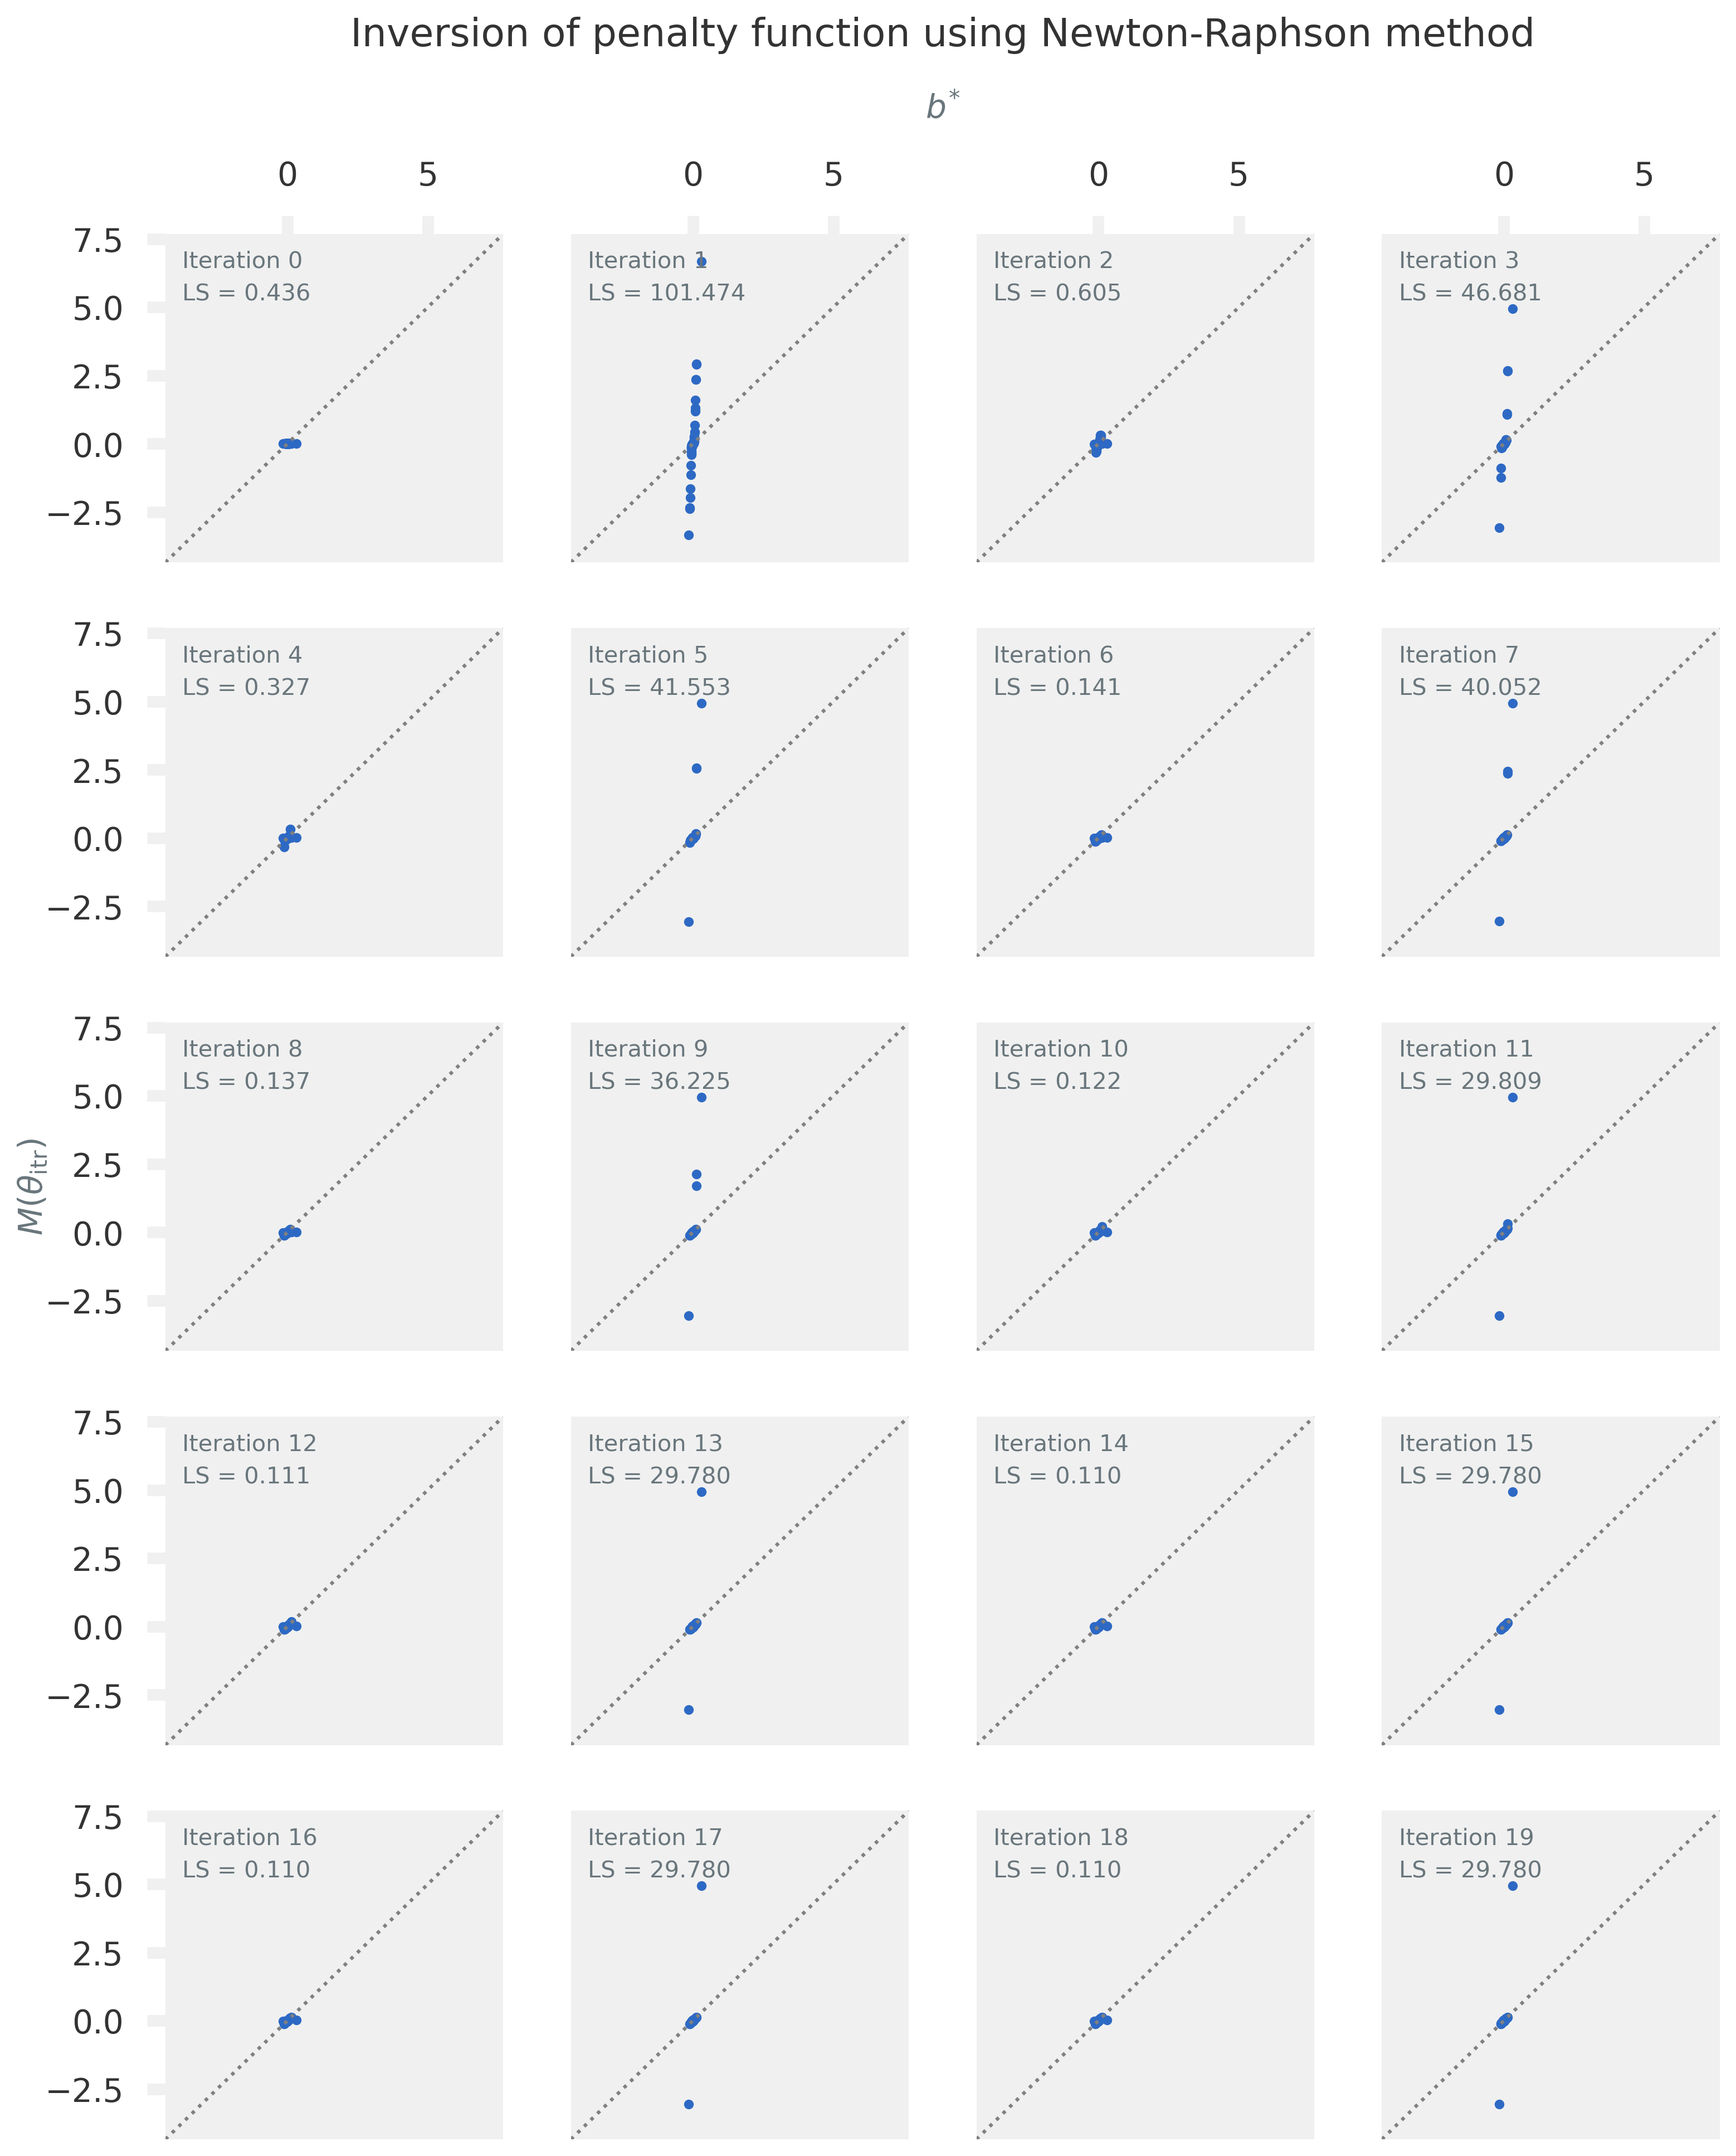

In [5]:
def newton_root_func(z, b, std, wk, sk, dj):
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj) 
    Mtheta = nmash.y + nmash.yvar * nmash.logML_deriv
    Mtheta_bgrad = 1 + nmash.yvar * nmash.logML_deriv2
    return Mtheta - b, Mtheta_bgrad

def rootfind_newton_raphson(func, x0, fprime, args=(), tol=1.48e-08, maxiter=50, full_output=None):
    resnorm = np.inf  # norm of residuals
    objpath = list()
    xpath   = list()
    for itr in range(maxiter):
        fval = func(x0, *args)
        if fprime is True:
            fval, jval = fval
        else:
            jval = fprime(x0, *args)
        resnorm = np.sum(fval**2)
        # keep full path if requested
        if full_output:
            xpath.append(x0.copy())
            objpath.append(resnorm)
        if resnorm < tol:
            break
        newton_step = fval / jval
        # do some clever damping here,
        # or use Numerical Recipes in C ch. 9.6-9.7 and do line search
        x0 -= newton_step
    if full_output:
         #return x0, fval, resnorm, newton_step, itr
        return x0, xpath, objpath
    return x0

theta_init = np.zeros(p)
t_newraph, tpath_newraph, obj_newraph = rootfind_newton_raphson(newton_root_func, theta_init, True,
                                                      args = (bconst, strue, wpost, sk, dj),
                                                      maxiter = 20,
                                                      full_output = True)
b_newraph = shrink_theta(t_newraph, strue, wpost, sk, dj)
print ("=================")
print ("||M(theta) - b||^2")
for obj in obj_newraph:
    print(obj)
print ("=================")
nstep = max(1, int(len(tpath_newraph) / 12))
plot_inversion_path(tpath_newraph, bconst, strue, wpost, sk, dj, method = "Newton-Raphson", 
                    nstep = nstep, objpath = obj_newraph)

### Bisection method

This is not a vector implementation. It finds the root of each element individually, that is, it finds the root  $\hat{\theta_j}$ for $M(\theta_j) - b_j^* = 0$ for each $j$ sequentially. This is slow but sure.

In [6]:
from scipy import optimize as sp_optimize

def rootfind_bisection(b, std, wk, sk, dj, theta = None, tmin = -6, tmax = 6):
    
    # the function to obtain individual M(theta) - b
    def bisect_func(zi, zall, idx, b, std, wk, sk, dj):
        z = zall.copy()
        z[idx] = zi
        Mb = shrink_theta(z, std, wk, sk, dj)
        res = Mb - b
        return res[idx]
    
    # this is the initial value of theta
    theta_path = list()
    obj_path = list()
    if theta is None:
        theta = b.copy()
    
    # Iterate over all vector values to obtain the inversion
    for i in range(b.shape[0]):
        sol = sp_optimize.root_scalar(bisect_func,
                        args = (theta, i, b, std, wk, sk, dj),
                        method = 'brentq',
                        bracket = [tmin, tmax])
        theta[i] = sol.root
        theta_path.append(theta.copy())
        #print (f"Index {i}, iteration {sol.iterations}, converged {sol.converged}, value {sol.root:.3f}")
        
    return theta, theta_path, obj_path

In [7]:
t_bisect, tpath_bisect, obj_bisect = rootfind_bisection(bconst, strue, wpost, sk, dj, theta = np.random.rand(p))

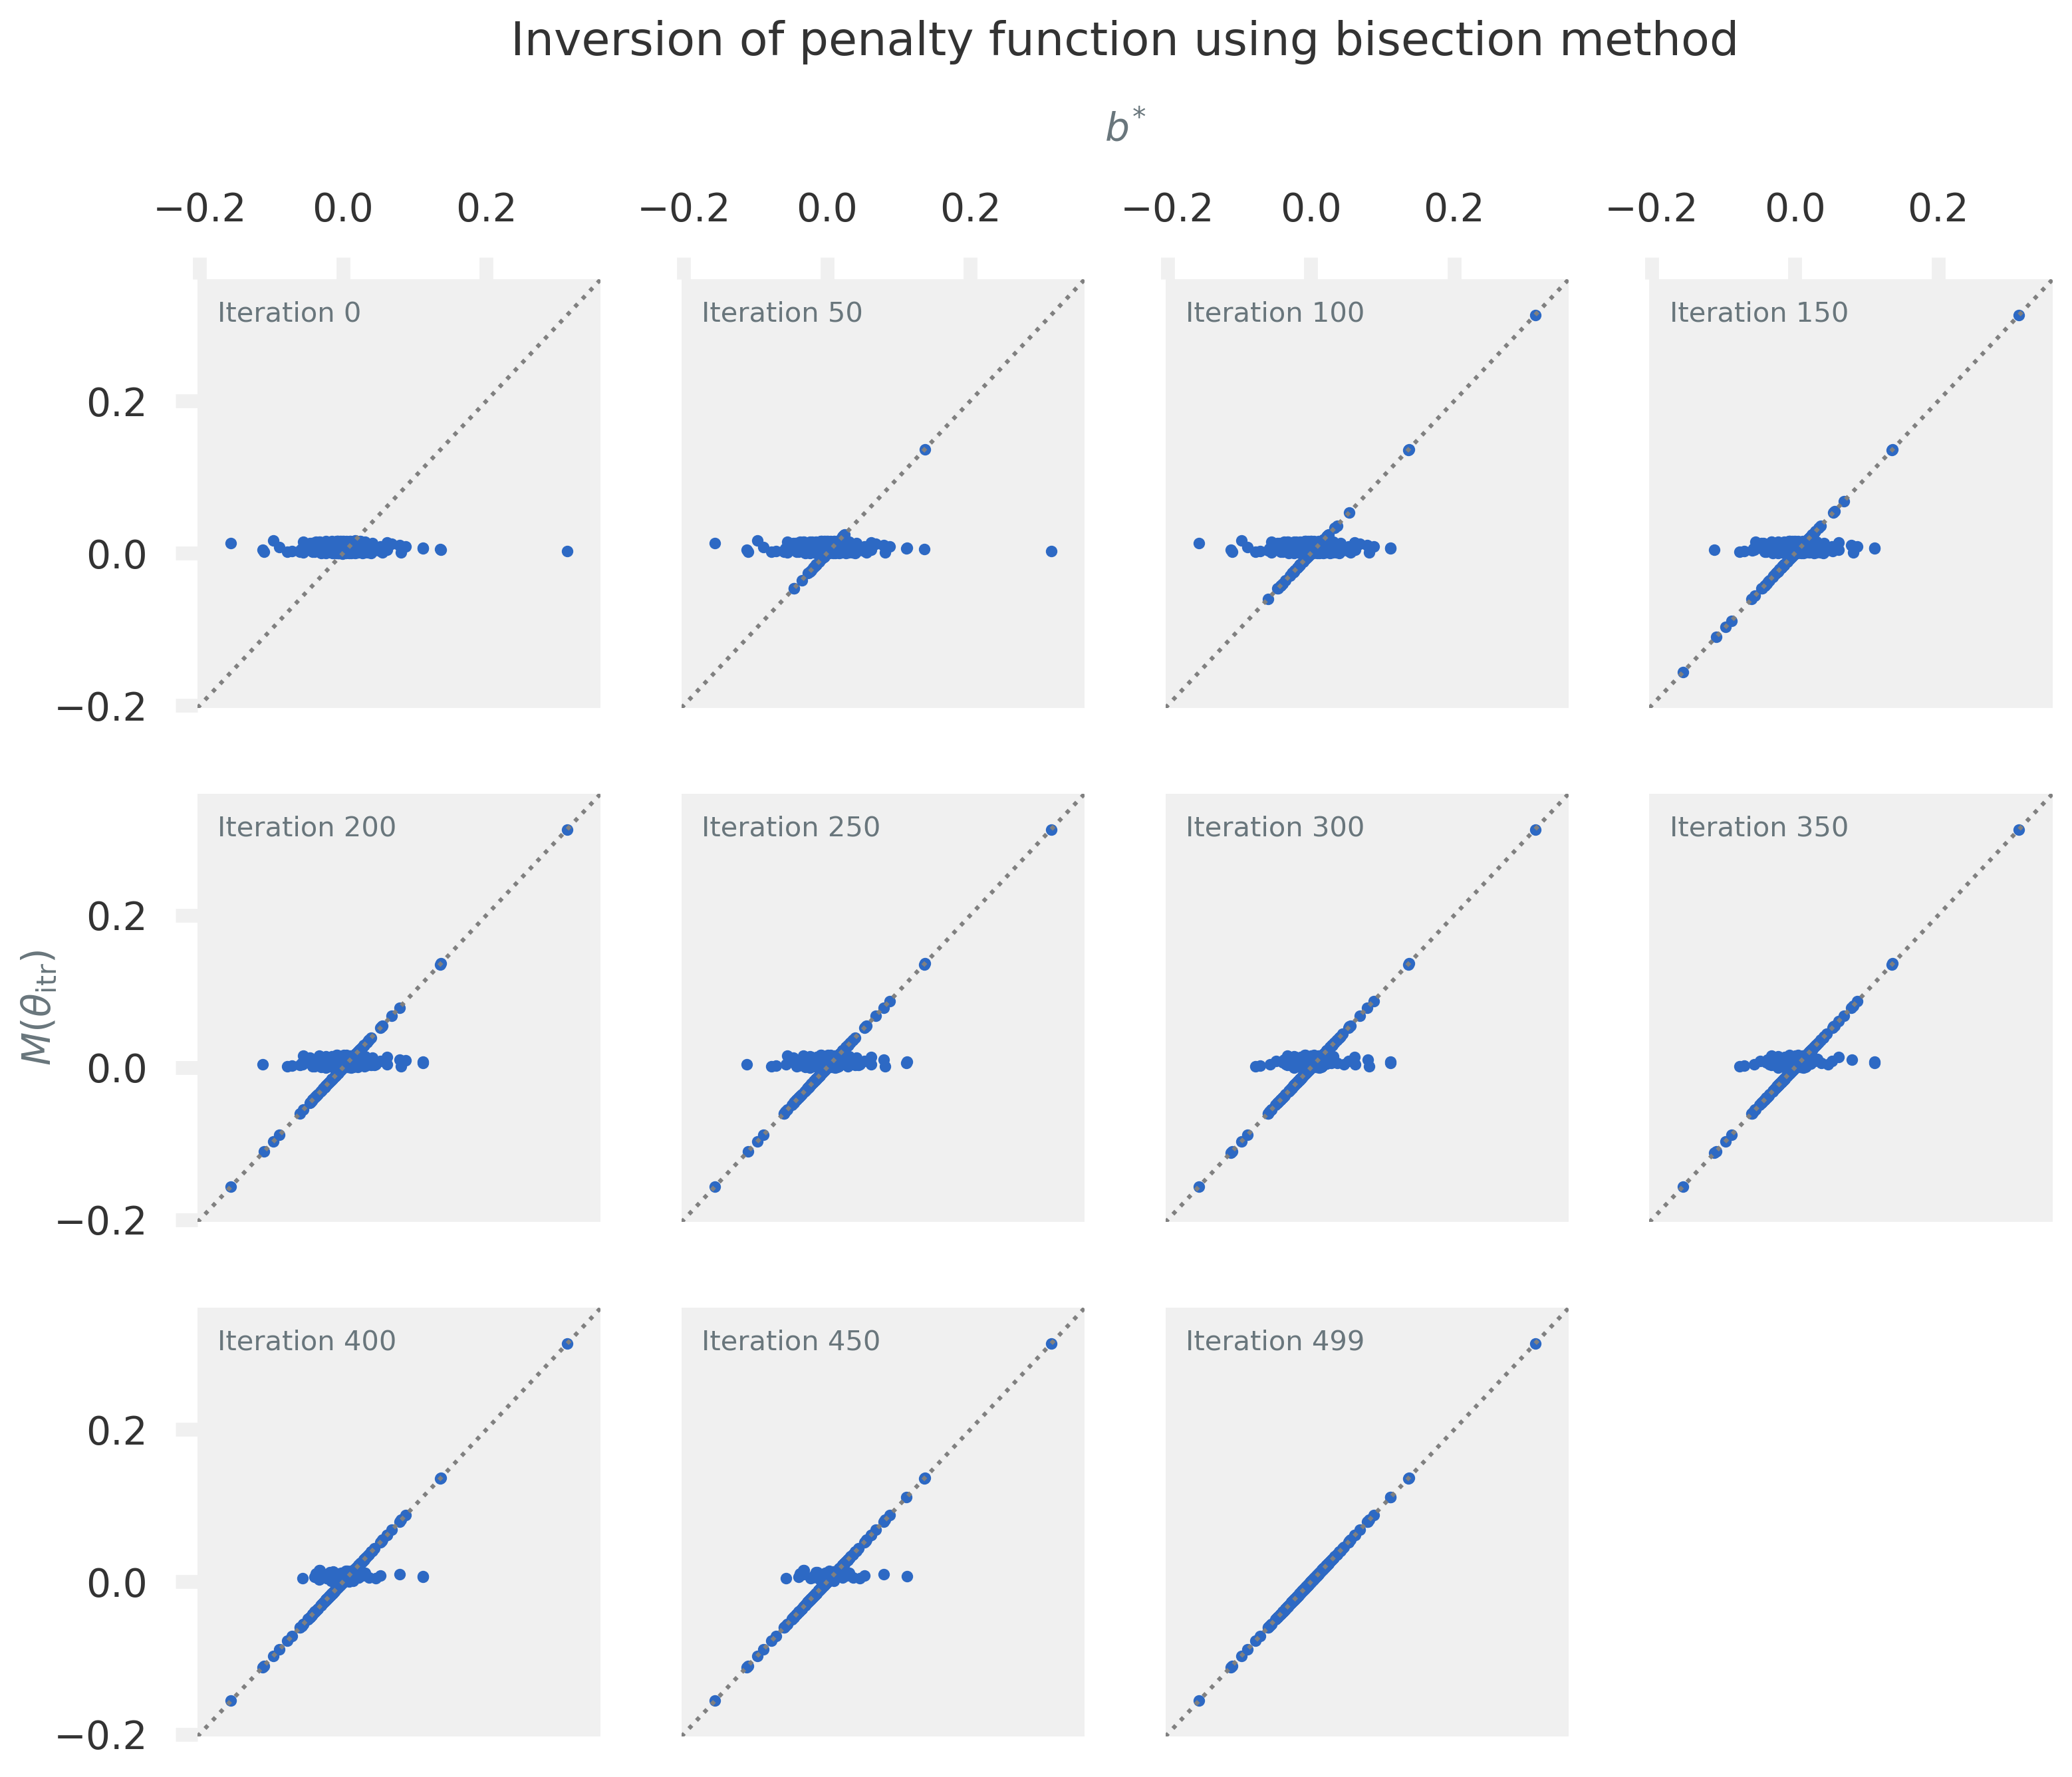

In [8]:
b_bisect = shrink_theta(t_bisect, strue, wpost, sk, dj)
# print ("=================")
# print ("rho(M(theta))")
# for obj in obj_newraph:
#     print(obj)
# print ("=================")
nstep = max(1, int(len(tpath_bisect) / 10))
plot_inversion_path(tpath_bisect, bconst, strue, wpost, sk, dj, method = "bisection", 
                    nstep = nstep)

### Powell's method

In [38]:
def powell_root_func(z, b, std, wk, sk, dj):
    return shrink_theta(z, std, wk, sk, dj) - b

theta_init = np.zeros(p)
powell_opt = sp_optimize.root(powell_root_func, theta_init, 
                              args = (bconst, strue, wpost, sk, dj),
                              method = 'hybr', jac = None, tol = 1e-8
                             )
t_powell = powell_opt.x

In [39]:
powell_opt.message

'The solution converged.'

In [40]:
powell_opt.keys()

dict_keys(['x', 'success', 'status', 'nfev', 'fjac', 'r', 'qtf', 'fun', 'message'])

In [41]:
np.sqrt(np.sum(np.square(powell_opt.fun)))

2.3950022342215906e-09

In [42]:
powell_opt.nfev

1536

In [43]:
sp_optimize.show_options(solver = 'root', method = 'hybr')

Find the roots of a multivariate function using MINPACK's hybrd and
hybrj routines (modified Powell method).

Options
-------
col_deriv : bool
    Specify whether the Jacobian function computes derivatives down
    the columns (faster, because there is no transpose operation).
xtol : float
    The calculation will terminate if the relative error between two
    consecutive iterates is at most `xtol`.
maxfev : int
    The maximum number of calls to the function. If zero, then
    ``100*(N+1)`` is the maximum where N is the number of elements
    in `x0`.
band : tuple
    If set to a two-sequence containing the number of sub- and
    super-diagonals within the band of the Jacobi matrix, the
    Jacobi matrix is considered banded (only for ``fprime=None``).
eps : float
    A suitable step length for the forward-difference
    approximation of the Jacobian (for ``fprime=None``). If
    `eps` is less than the machine precision, it is assumed
    that the relative errors in the functions are

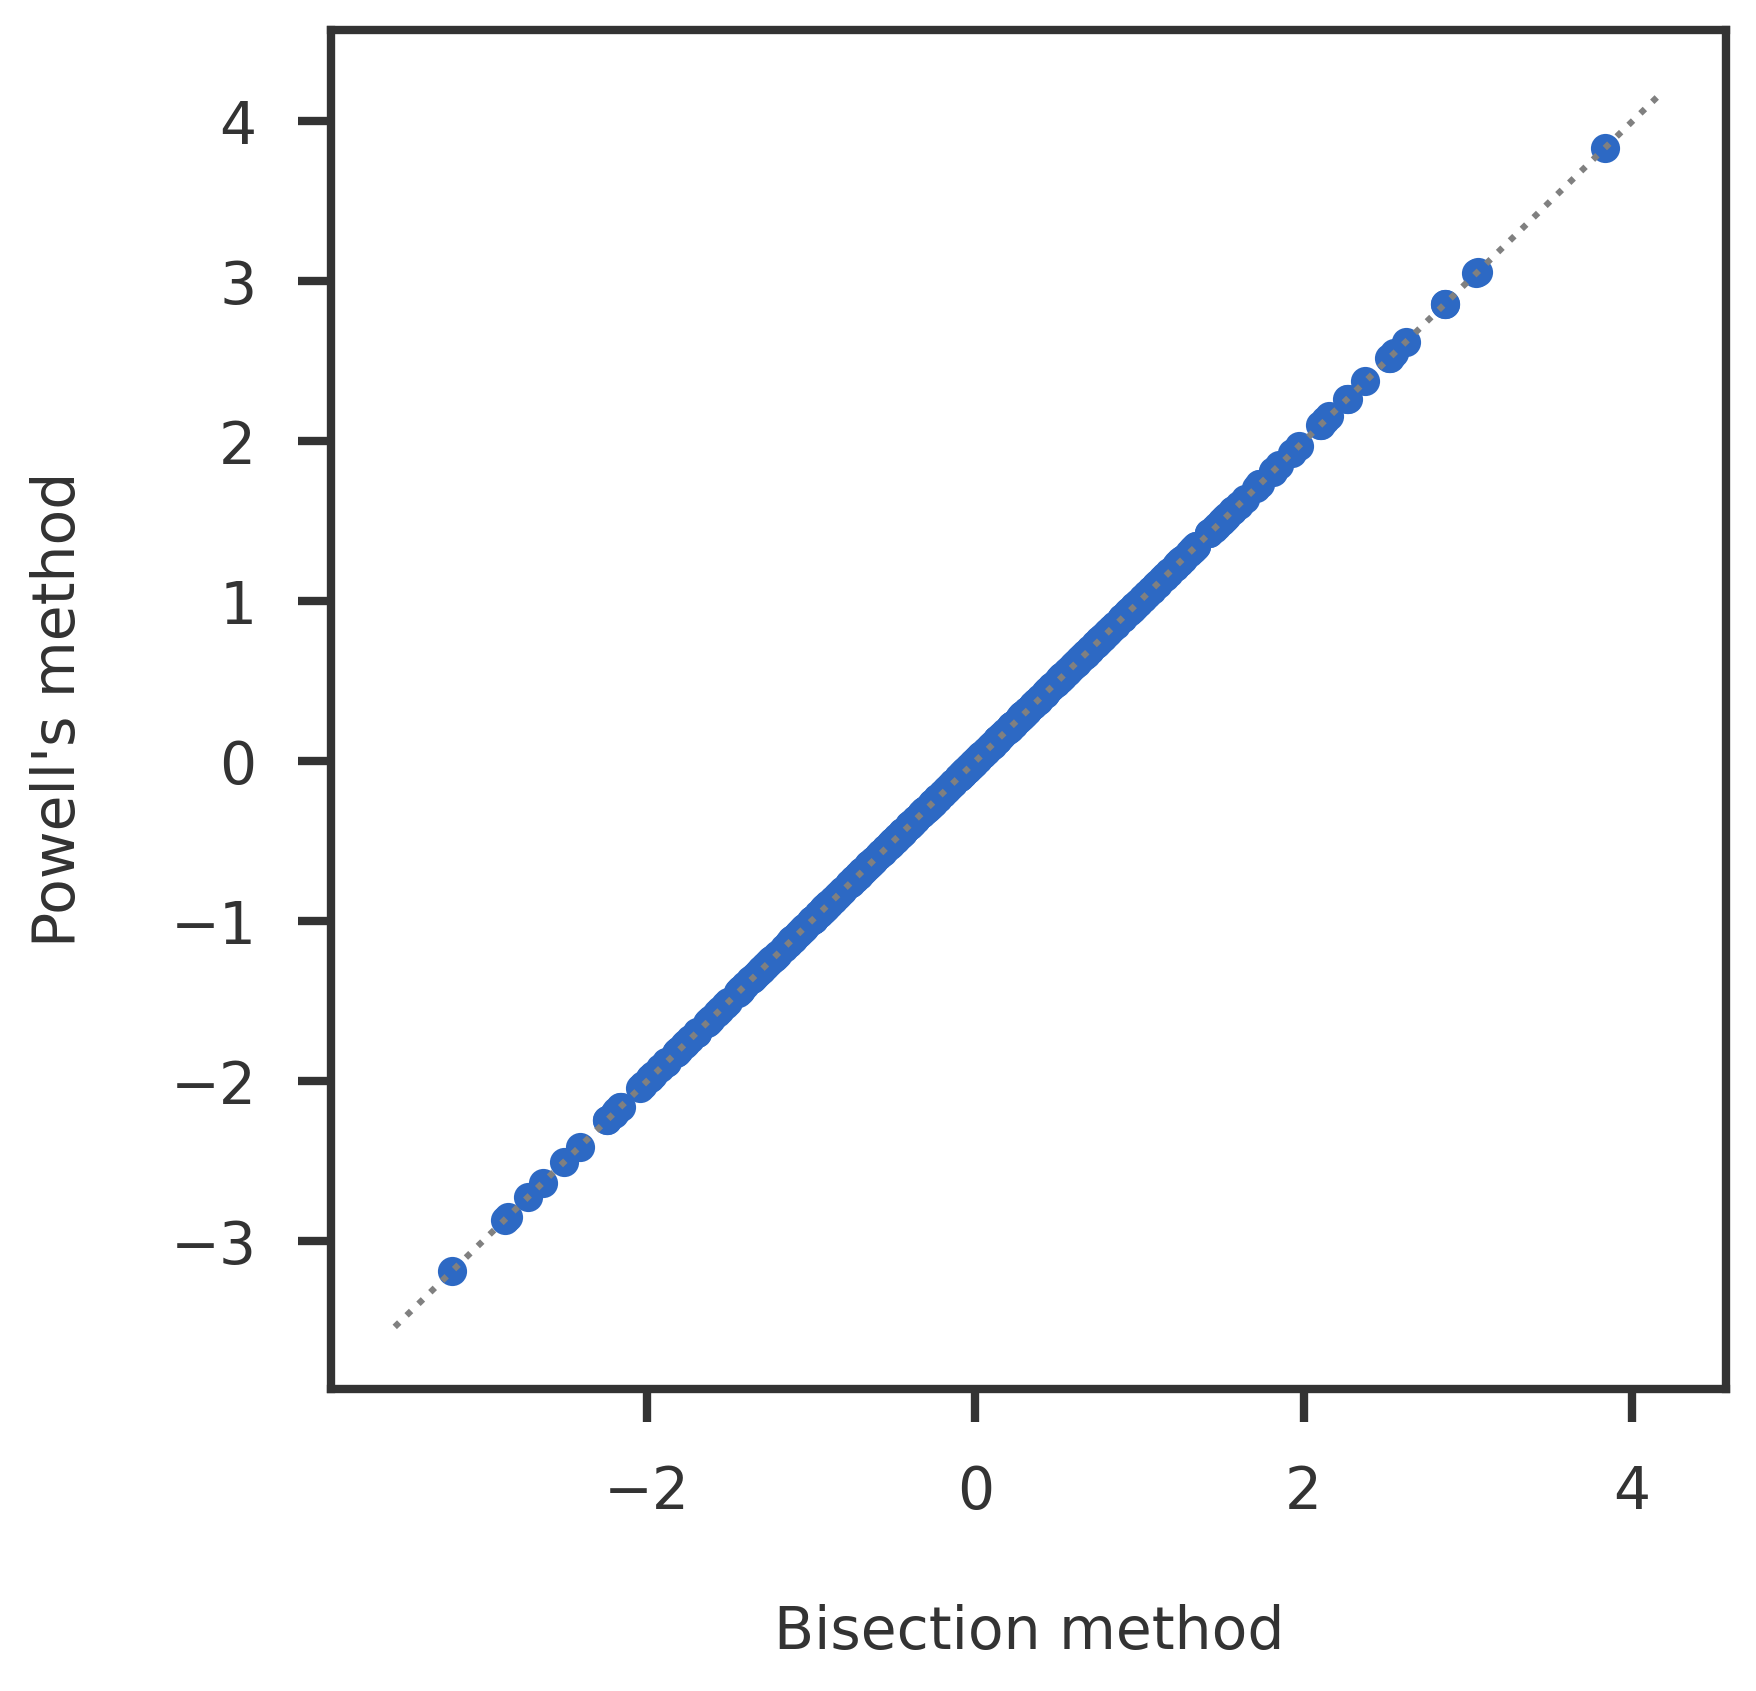

In [44]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(t_bisect, t_powell)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel ("Bisection method")
ax1.set_ylabel ("Powell's method")
plt.show()

### Broyden's method

In [13]:
theta_init = np.zeros(p)
broyden1_opt = sp_optimize.root(powell_root_func, theta_init, 
                                args = (bconst, strue, wpost, sk, dj),
                                method = 'broyden1', jac = None)
t_broyden = broyden1_opt.x

In [14]:
broyden1_opt.message

'A solution was found at the specified tolerance.'

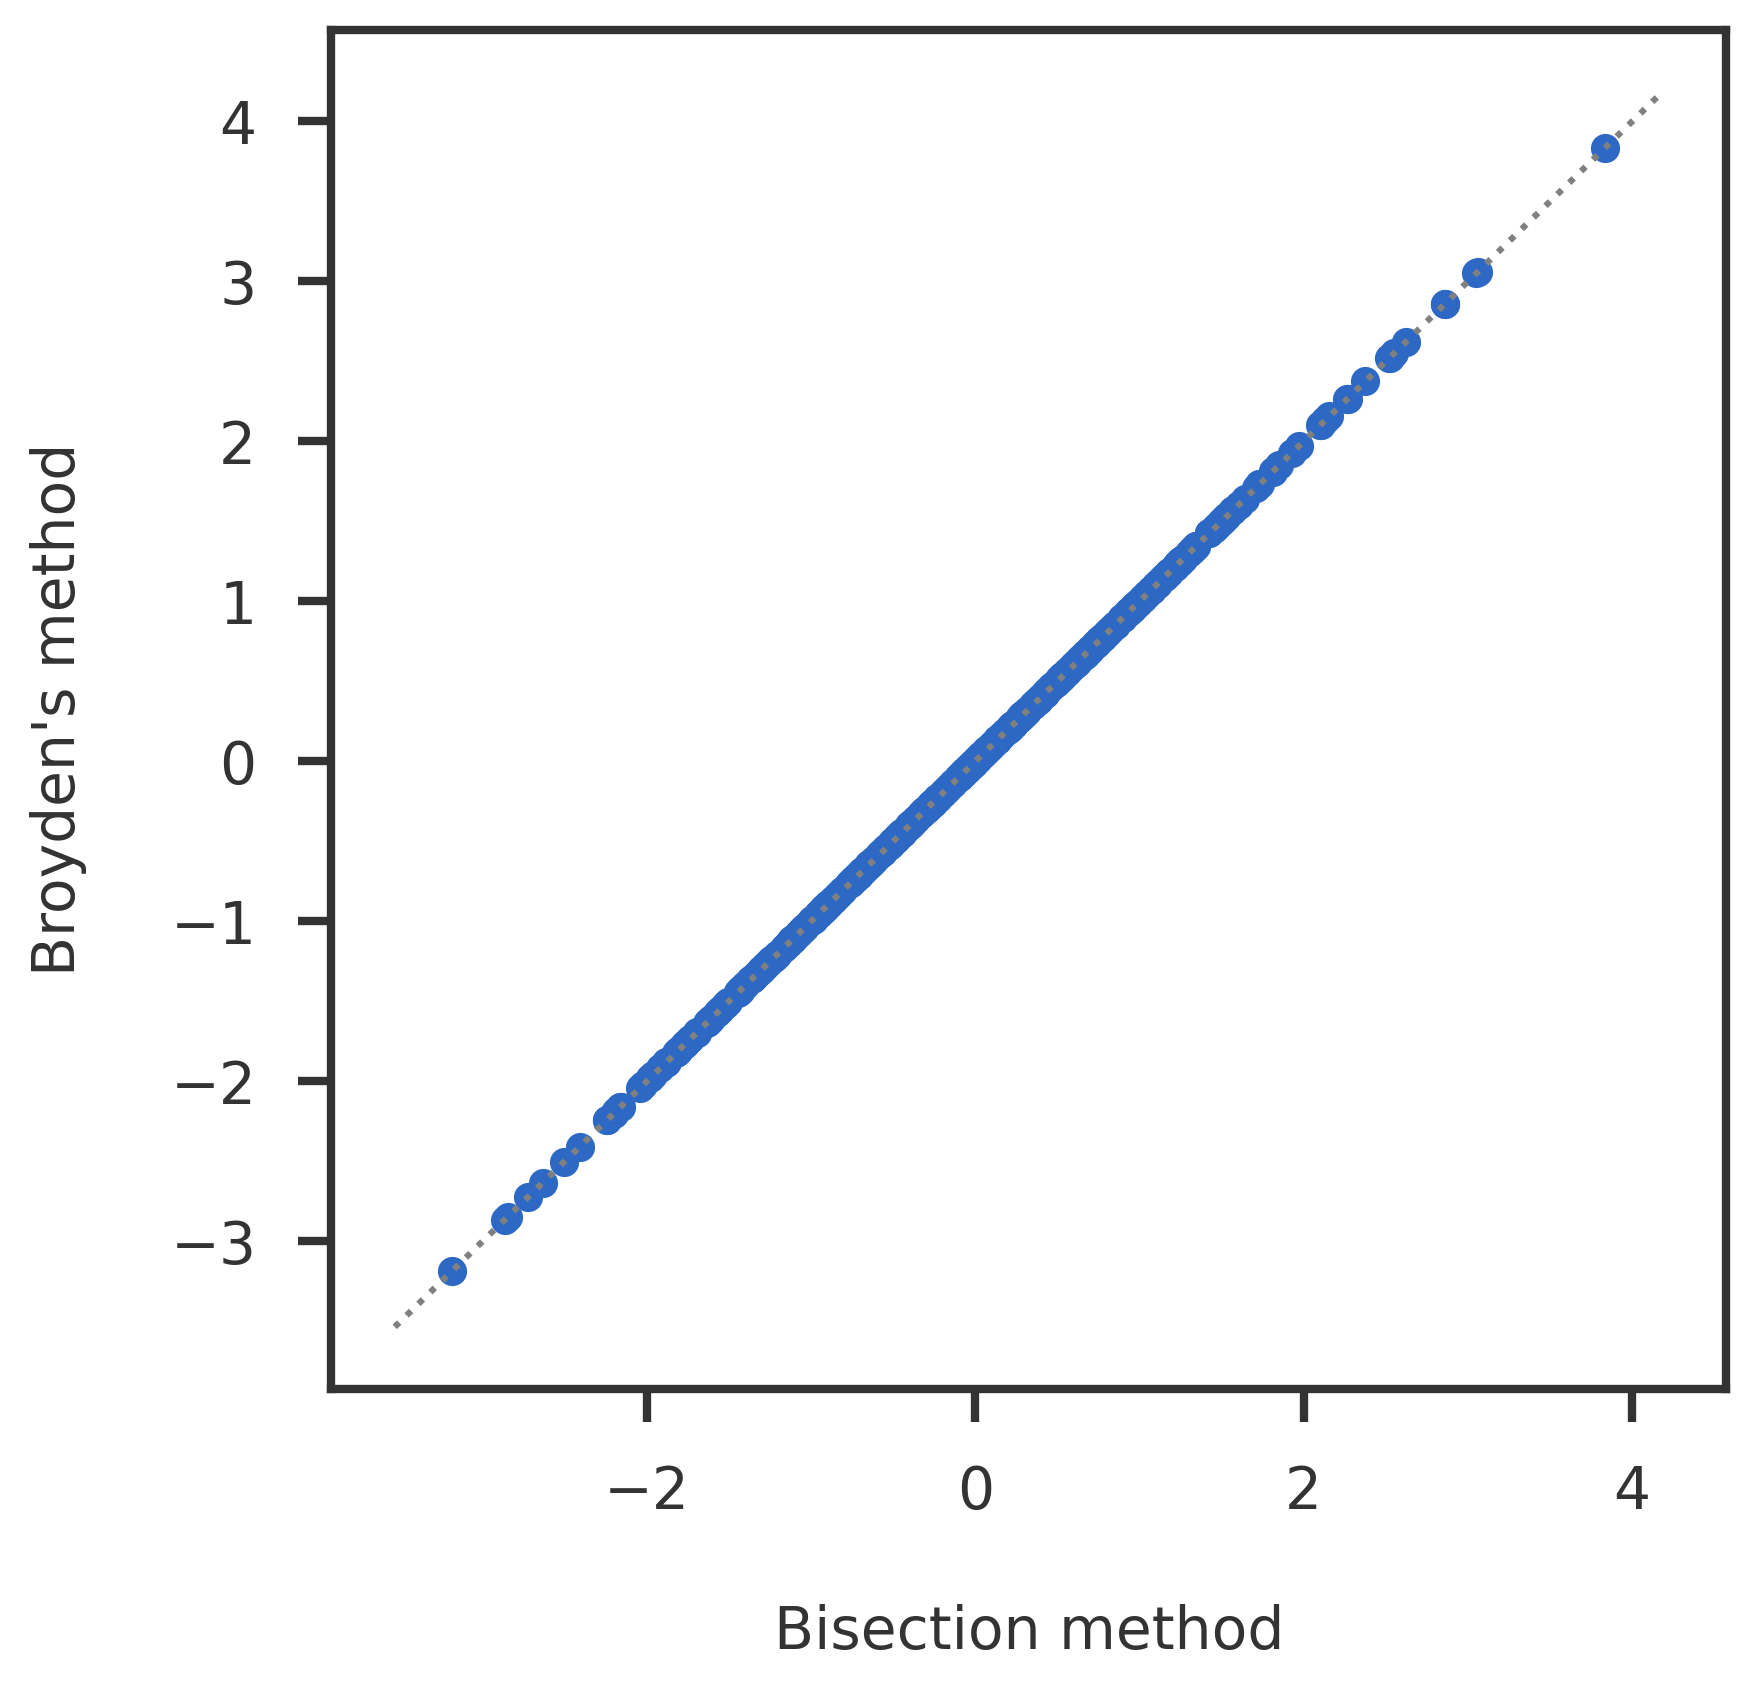

In [15]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(t_bisect, t_broyden)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel ("Bisection method")
ax1.set_ylabel ("Broyden's method")
plt.show()